# Invertible Neural Networks

- Forward model is well defined, but inverse problem is ill defined:   



 
<img src="car.png" alt="My Diagram" width="500px"/>



## Look at the distribution of 4-wheels vehicles in the population

<img src="4_wheels_veicles_distribution.png" alt="My Diagram" width="500px"/>


## The pdf conditioned on the observation is 


<img src="pdf_4_wheels.png" alt="My Diagram" width="500px"/>


# The problem of the robotic arm
(Ardizzone et Al.)


A robotic arm, made of
- 4 free segments and 3 joints
- bounded to the wall
- free on the other side

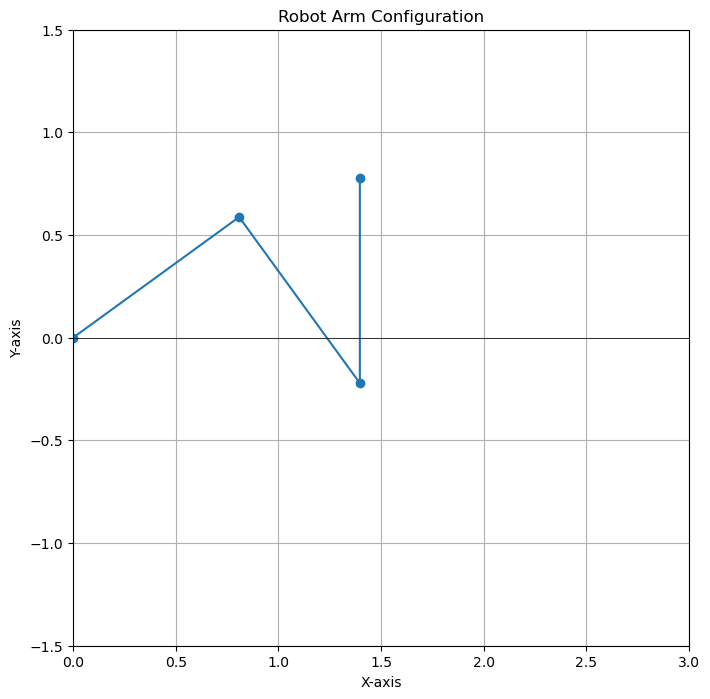

In [2]:
import numpy as np


angle_joint_wall= 0.2*np.pi
angle_joint1= -0.3*np.pi
angle_joint2= 0.5*np.pi

point1= np.array([0.0, 0.0])
point2= np.array([np.cos(angle_joint_wall), np.sin(angle_joint_wall)])
point3= point2 + np.array([np.cos(angle_joint1), np.sin(angle_joint1)])
point4= point3 + np.array([np.cos(angle_joint2), np.sin(angle_joint2)])

points= np.array([point1, point2, point3, point4])

#plot the points with segments connecting them
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.plot(points[:, 0], points[:, 1], marker='o')
plt.xlim(0, 3)
plt.ylim(-1.5, 1.5)
plt.axhline(0, color='black', lw=0.5)
plt.axvline(0, color='black', lw=0.5)
plt.grid()
plt.title("Robot Arm Configuration")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# Now set a uniform prior for each angle, to be in the range $[-\pi/2 + \pi/2]$

In [3]:
import numpy as np
from numba import njit, prange
import matplotlib.pyplot as plt

@njit(parallel=True)
def compute_arms(angles):
    n = angles.shape[0]
    pts = np.zeros((n, 4, 2), dtype=np.float64)
    for i in prange(n):
        # base
        pts[i, 0, 0] = 0.0
        pts[i, 0, 1] = 0.0
        # first segment
        x1 = np.cos(angles[i, 0])
        y1 = np.sin(angles[i, 0])
        pts[i, 1, 0] = x1
        pts[i, 1, 1] = y1
        # second segment
        x2 = x1 + np.cos(angles[i, 1])
        y2 = y1 + np.sin(angles[i, 1])
        pts[i, 2, 0] = x2
        pts[i, 2, 1] = y2
        # third segment
        x3 = x2 + np.cos(angles[i, 2])
        y3 = y2 + np.sin(angles[i, 2])
        pts[i, 3, 0] = x3
        pts[i, 3, 1] = y3
    return pts

# --------------------------------------------------
# Usage
np.random.seed(42)
num_arms = 1000000
angles = np.random.normal(0, np.pi/4, size=(num_arms, 3))

# First call will compile; subsequent calls are very fast
points = compute_arms(angles)
print(points.shape)  # Should be (10000, 4, 2)

/home/francesco/.local/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


(1000000, 4, 2)


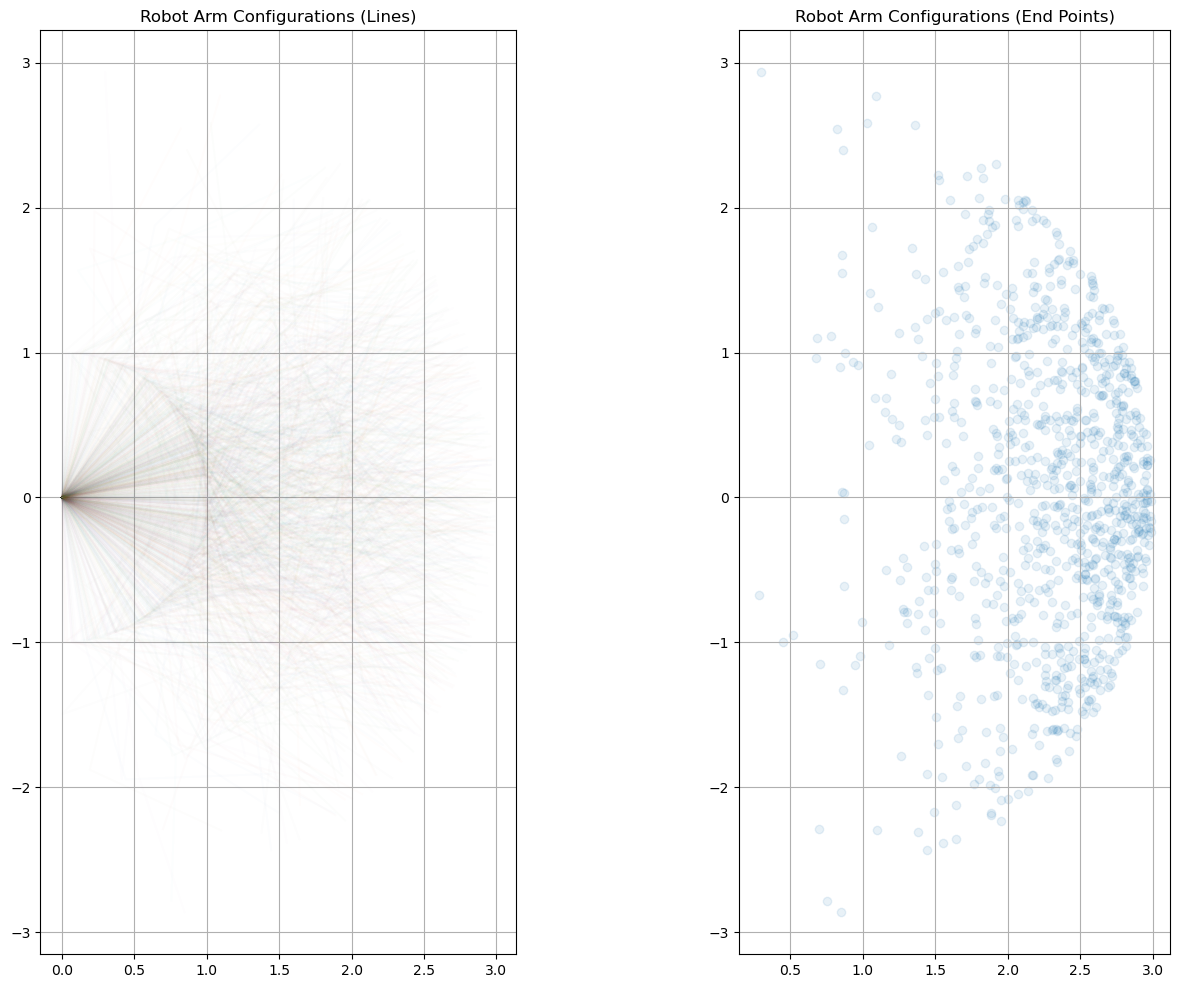

In [4]:
mask = (points[:, 1, 0] >= 0) & (points[:, 2, 0] >= 0) & (points[:, 3, 0] >= 0)

n_shown= 1000
# apply it
points = points[mask]

# Plot as before
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 12))
ax1.set_title("Robot Arm Configurations (Lines)")
for pts in points[:n_shown]:
    ax1.plot(pts[:,0], pts[:,1], alpha=0.01)
ax1.set_aspect('equal')
ax1.grid()

ax2.set_title("Robot Arm Configurations (End Points)")
ax2.scatter(points[:n_shown,3,0], points[:n_shown,3,1], alpha=0.1)
ax2.set_aspect('equal')
ax2.grid()

plt.show()


# Lets say I observe the endpoint of the arm in a particular position, what can I say about the joint angles?

An Approximate bayesian approach

In [6]:

# Assume `filtered_points` array is defined with shape (M, 4, 2)
fp = points  # rename for clarity

# Define target circle (reuse if already defined)
center = np.array([2.4, -1.0])
r = 0.1

# Recompute mask on filtered_points
endpoints = fp[:, 3, :]
inside = np.sum((endpoints - center)**2, axis=1) <= r**2

# Number of joints/segments to plot (4 here)
n_shown = fp.shape[1]

# Vectorized plotting
fig, ax = plt.subplots(figsize=(6, 6))

# Plot all arms (gray)
x_all = fp[:, :n_shown, 0].T  # shape (n_shown, M)
y_all = fp[:, :n_shown, 1].T
ax.plot(x_all, y_all, color='gray', alpha=0.1)

# Highlighted arms (red)
x_in = fp[inside, :n_shown, 0].T  # shape (n_shown, K)
y_in = fp[inside, :n_shown, 1].T
ax.plot(x_in, y_in, color='red', alpha=0.5)

# Draw circle
circle = plt.Circle(center, r, fill=False, linewidth=2)
ax.add_patch(circle)

# Formatting
ax.set_aspect('equal')
ax.set_xlim(center[0] - r - 1, center[0] + r + 1)
ax.set_ylim(center[1] - r - 1, center[1] + r + 1)
ax.grid()
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_title("Filtered Arms with Selected Endpoints Highlighted")

plt.show()


: 